## 15.1 RSI

In [16]:
!pip install pykrx -qq

In [17]:
from pykrx import stock

df = stock.get_market_ohlcv_by_date("20000101", "20191231", "005930")
df = df[['종가']]
df.head()

,종가
날짜,
2000-01-04,6110
2000-01-05,5580
2000-01-06,5620
2000-01-07,5540
2000-01-10,5770


In [18]:
df['변화량'] = df['종가'] - df['종가'].shift(1)
df.loc[df['변화량'] >= 0, '상승폭'] = df['변화량']
df.loc[df['변화량'] < 0, '하락폭'] = -df['변화량']
df = df.fillna(0)
df.head()

,종가,변화량,상승폭,하락폭
날짜,,,,
2000-01-04,6110,0.0,0.0,0.0
2000-01-05,5580,-530.0,0.0,530.0
2000-01-06,5620,40.0,40.0,0.0
2000-01-07,5540,-80.0,0.0,80.0
2000-01-10,5770,230.0,230.0,0.0


In [19]:
df['AU'] = df['상승폭'].rolling(14).mean()
df['DU'] = df['하락폭'].rolling(14).mean()
df['RSI'] = df['AU'] / (df['AU'] + df['DU']) * 100
df.iloc[12:].head()

,종가,변화량,상승폭,하락폭,AU,DU,RSI
날짜,,,,,,,
2000-01-20,6040,80.0,80.0,0.0,NaN,NaN,NaN
2000-01-21,5880,-160.0,0.0,160.0,52.857143,69.285714,43.274854
2000-01-24,5700,-180.0,0.0,180.0,52.857143,82.142857,39.153439
2000-01-25,5440,-260.0,0.0,260.0,52.857143,62.857143,45.679012
2000-01-26,5480,40.0,40.0,0.0,52.857143,62.857143,45.679012


In [20]:
df['AU'] = df['상승폭'].ewm(span=14, adjust=False).mean()
df['DU'] = df['하락폭'].ewm(span=14, adjust=False).mean()
df['RSI'] = df['AU'] / (df['AU'] + df['DU']) * 100
df.iloc[12:].head()

,종가,변화량,상승폭,하락폭,AU,DU,RSI
날짜,,,,,,,
2000-01-20,6040,80.0,80.0,0.0,54.163800,37.238665,59.258577
2000-01-21,5880,-160.0,0.0,160.0,46.941960,53.606843,46.685747
2000-01-24,5700,-180.0,0.0,180.0,40.683032,70.459264,36.604455
2000-01-25,5440,-260.0,0.0,260.0,35.258628,95.731362,26.917040
2000-01-26,5480,40.0,40.0,0.0,35.890811,82.967180,30.196380


<Axes: xlabel='날짜'>

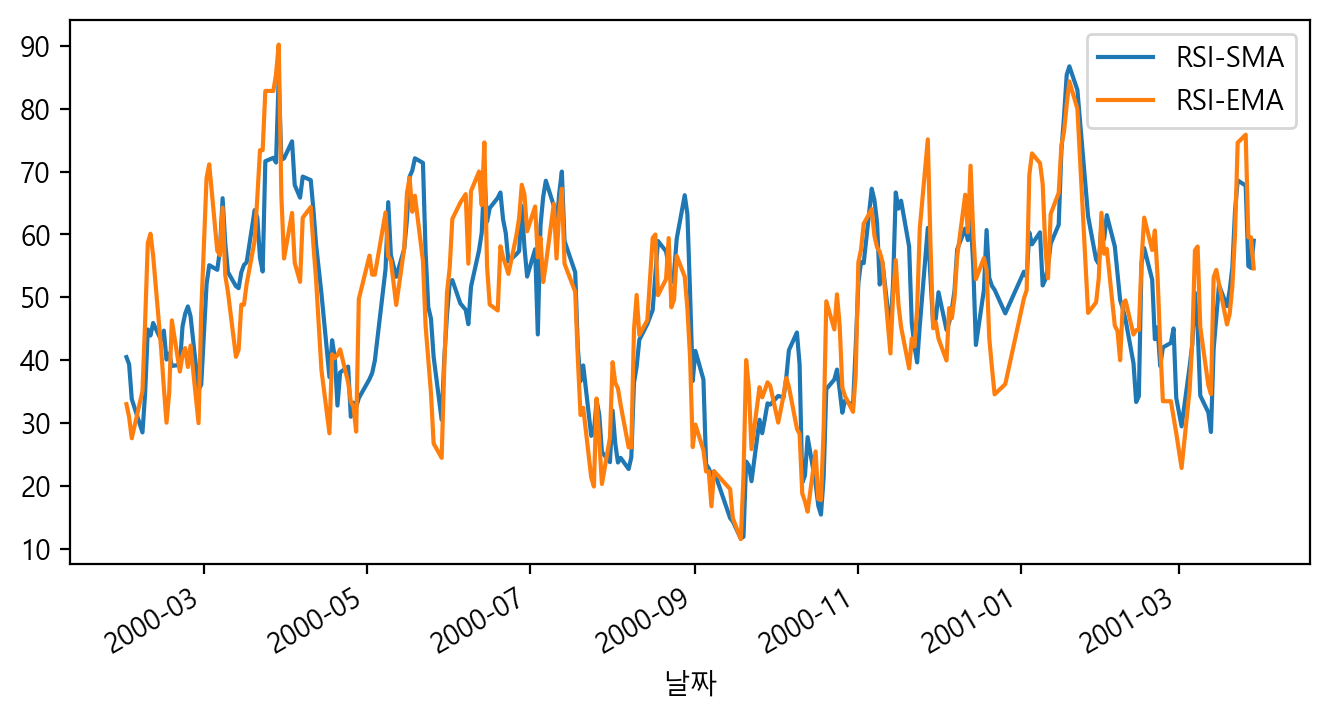

In [21]:
df['AU'] = df['상승폭'].rolling(14).mean()
df['DU'] = df['하락폭'].rolling(14).mean()
df['RSI-SMA'] = df['AU'] / (df['AU'] + df['DU']) * 100

df['AU'] = df['상승폭'].ewm(span=14, adjust=False).mean()
df['DU'] = df['하락폭'].ewm(span=14, adjust=False).mean()
df['RSI-EMA'] = df['AU'] / (df['AU'] + df['DU']) * 100

df[['RSI-SMA', 'RSI-EMA']].iloc[20:300].plot(figsize=(8, 4))

## 15.2 RSI 전략 백테스팅

In [22]:
from pykrx import stock
import numpy as np

df = stock.get_market_ohlcv_by_date("20000101", "20191231", "005930")
df = df[['종가']]

df['변화량'] = df['종가'] - df['종가'].shift(1)
df.loc[df['변화량'] >= 0, '상승폭'] = df['변화량']
df.loc[df['변화량'] < 0, '하락폭'] = -df['변화량']
df = df.fillna(0)

df['AU'] = df['상승폭'].rolling(14).mean()
df['DU'] = df['하락폭'].rolling(14).mean()
df['RSI'] = df['AU'] / (df['AU'] + df['DU']) * 100
df = df[['종가', 'RSI']]
df.head()

,종가,RSI
날짜,,
2000-01-04,6110,NaN
2000-01-05,5580,NaN
2000-01-06,5620,NaN
2000-01-07,5540,NaN
2000-01-10,5770,NaN


In [23]:
df['일간수익률'] = df['종가'].pct_change() + 1

In [24]:
df.loc[df['RSI'] < 30, '매매신호'] = True
df.loc[df['RSI'] > 70, '매매신호'] = False

In [25]:
# 전날 종가 매수면 당일은 보유
df.loc[df['매매신호'].shift(1) == True, '보유여부'] = True

# 전날 종가 매도면 당일은 미보유
df.loc[df['매매신호'].shift(1) == False, '보유여부'] = False

# 매수/매도 조건이 아니라면 전일 상태 유지
df['보유여부'].ffill(inplace=True)
df['보유여부'].fillna(False, inplace=True)

C:\Users\campus3S031\AppData\Local\Temp\ipykernel_73616\2545405995.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['보유여부'].ffill(inplace=True)
C:\Users\campus3S031\AppData\Local\Temp\ipykernel_73616\2545405995.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['보유여부'].fillna(False, inplace=True)


In [26]:
# df.loc['2000-02-03':].head(10)

In [27]:
df['보유수익률'] = df.loc[ df['보유여부'] == True, '일간수익률']
df['보유수익률'].fillna(1, inplace=True)

C:\Users\campus3S031\AppData\Local\Temp\ipykernel_73616\4261414041.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['보유수익률'].fillna(1, inplace=True)


In [28]:
df['RSI수익률'] = df['보유수익률'].cumprod()
df['단순보유수익률'] = df['종가'] / df.iloc[0, 0]
df.tail()

,종가,RSI,일간수익률,매매신호,보유여부,보유수익률,RSI수익률,단순보유수익률
날짜,,,,,,,,
2019-12-23,55500,81.460674,0.991071,False,False,1.0,4.836518,9.083470
2019-12-24,55000,81.005587,0.990991,False,False,1.0,4.836518,9.001637
2019-12-26,55400,81.720430,1.007273,False,False,1.0,4.836518,9.067103
2019-12-27,56500,82.105263,1.019856,False,False,1.0,4.836518,9.247136
2019-12-30,55800,74.468085,0.987611,False,False,1.0,4.836518,9.132570


<Axes: xlabel='날짜'>

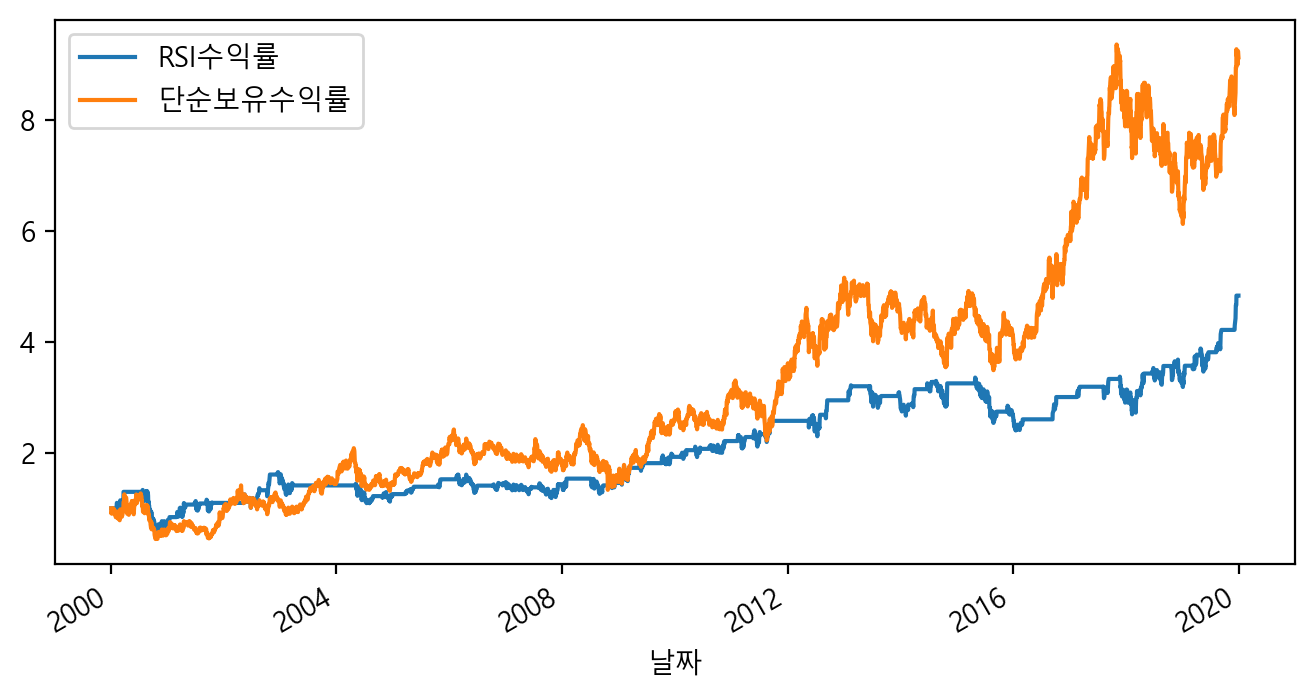

In [29]:
import matplotlib.pyplot as plt 
import platform
plt.rcParams['figure.dpi'] = 200

# 한글처리
if platform.system() == 'Darwin':
    plt.rc('font', family='AppleGothic') 
else:
    plt.rc('font', family='Malgun Gothic') 
    
df[['RSI수익률', '단순보유수익률']].plot(figsize=(8, 4))